# Diffusion Models

![title](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/generative-overview.png)

## What exactly do we mean by “Diffusion” ?

* In thermodynamics, “Diffusion” refers to the flow of particles from high-density regions towards low-density regions. In the context of statistics, meaning of Diffusion is quite similar, i.e. the process of transforming a complex distribution $p_{complex}$ on $\mathbb{R}^d$ to a simple (predifined) distribution $p_{prior}$ on the same domain $\mathbb{R}^d$.

![title](https://ayandas.me/assets/posts_res/20/diffusion_over_time.png)

## Generative modelling by undoing the diffusion process

* There is a stochastic transform ($\mathcal{T}$) that does the diffusion process
* Note that the diffusion process does not depend on the initial density $p_{complex}$ (as $t \to \infty$). the only requirement is to be able to sample from it.

* Use any data distribution (say $p_{data}$) of our choice as the complex initial density. Then do the forward diffusion process:


$$X_0 \sim p_{\text{data}} \quad \Rightarrow \quad X_{T} = \mathcal{T}(X_0) \sim \mathcal{N}(0, I)$$

* This process is responsible for “destructuring” the data and turning it into an isotropic gaussian (almost structureless).

![title](https://ayandas.me/assets/posts_res/20/fwddiff.gif)


However, this isn’t very usefull by itself. What would be useful is doing the opposite, i.e. starting from isotropic gaussian noise and turning it into $p_{data}$

![title](https://ayandas.me/assets/posts_res/20/revdiff.gif)

Diffusion models are fundamentally different from all the previous generative methods. Intuitively, they aim to decompose the image generation process (sampling) in many small “denoising” steps.

The intuition behind this is that the model can correct itself over these small steps and gradually produce a good sample. To some extent, this idea of refining the representation has already been used in models like alphafold. But hey, nothing comes at zero-cost. This iterative process makes them slow at sampling, at least compared to GANs.

### Diffusion process

* The basic idea behind diffusion models is rather simple. They take the input image x₀ and gradually add Gaussian noise to it through a series of T steps.
* This is unrelated to the model forward pass. The forward pass here is to create targets for the model to learn from.
* Afterward, a neural network is trained to recover the original data by reversing the noising process. By being able to model the reverse process, we can generate new data. This is the so-called reverse diffusion process or, in general, the sampling process of a generative model.

### Forward diffusion

* Diffusion models can be seen as latent variable models. Latent means that we are referring to a hidden continuous feature space.
* In practice, they are formulated using a Markov chain of T steps. Here, a Markov chain means that each step only depends on the previous one.
* Given a data-point x₀ sampled from the real data distribution q(x) (x₀ ∼ q(x)), one can define a forward diffusion process by adding noise. Specifically, at each step of the Markov chain we add Gaussian noise with variance βₜ to xₜ₋₁, producing a new latent variable xₜ with distribution q(xₜ | xₜ₋₁).


![title](https://theaisummer.com/static/1f5f940d6d3f1e00b3777066f6695331/073e9/forward-diffusion.png)

$$q(x_t \mid x_{t-1}) = \mathcal{N}(x_t; \mu_t = \sqrt{(1-\beta_t)} x_{t-1}, \Sigma_t = \beta_t I)$$

* Each dimension has the same standard deviation βₜ

$$ q(x_{1:T} \mid x_0) = \prod_{t=1}^T q(x_t \mid x_{t-1}) $$

So far, so good? Well, nah! For timestep $ t = 500 < T $ we need to apply $ q $ 500 times in order to sample $x_t$. Can't we really do better?

Define:
* $\alpha_t = 1 - \beta_t$
* $\bar{\alpha}_t = \prod_{s=0}^t \alpha_s$
* $\epsilon_0, \ldots, \epsilon_{t-2}, \epsilon_{t-1} \sim \mathcal{N}(0, I)$


$$x_t = \sqrt{(1-\beta_t)} x_{t-1} + \sqrt{\beta_t} \epsilon_{t-1}$$    
$$= \alpha_t x_{t-2} + (1-\alpha_t) \epsilon_{t-2}$$    
$$= \ldots $$    
$$= \bar{\alpha}_t x_0 + (1-\bar{\alpha}_t) \epsilon_0 $$


Thereby, to produce a sample $x_t$:
$$ x_t \sim q(x_t \mid x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t)I) $$

* $\beta_t$ is the variance of the Gaussian noise added at step t - is a hyperparameter - so we can precompute $\alpha_t$ and $\bar{\alpha}_t$ for all timesteps. - which means we can sample $x_t$ in a single step.

Hence we can sample the latent variable $x_t$ at any arbitrary timestep. Which will be the target later on for the model to learn from.

#### Variance Schedule

* The variance parameter $\beta_t$ can be fixed to a constant or chosen as a schedule over the $T$ timesteps.

![title](https://theaisummer.com/static/074ccf8c4830e7cdf07c68a0f1ef1864/2e195/variance-schedule.png)

#### Reverse Diffusion

As T → ∞, the latent $x_T$ is nearly an isotropic Gaussian distribution. Therefore, if we manage to learn the reverse distribution $q(x_{t-1} | x_t)$, we can sample $x_T$ from $N(0, I)$, run the reverse process, and acquire a sample from $q(x_0)$, generating a novel data point from the original data distribution

#### Approximating the reverse process with a neural network

* In practical terms, we don't know q(x_{t-1} | x_t). It's intractable since statistical estimates of q(x_{t-1} | x_t) require computations involving the data distribution.

* Instead, we approximate $q(x_{t-1} | x_t)$ with a parameterized model $p_{theta}$ (e.g., a neural network)

![title](https://theaisummer.com/static/9bb372bb74034360fe7891d546e3c5b4/01dae/reverse-diffusion.png)

$$p_{\theta}(x_{t-1} | x_t) = N(x_{t-1}; \mu_{\theta}(x_t, t), \Sigma_{\theta}(x_t, t))$$
$$p_{\theta}(x_{0:T}) = p_{\theta}(x_T) \prod_{t=1}^T p_{\theta}(x_{t-1} | x_t)$$

* learn to predict the Gaussian parameters (meaning the mean $\mu_{\theta}(x_t, t)$ and the covariance matrix $\Sigma_{\theta}(x_t, t))$ for each timestep.

* Starting from the noise, the model learns to predict the noise that was added at each step and then uses this prediction to iteratively refine and reconstruct the original data by guiding the reverse diffusion process. Each step effectively brings the noisy data closer to its original state, reducing the randomness incrementally until a clear, coherent image or sample is formed.

## Training

After lots of math:

$$logp(x) ≥ E_{q(x_1 | x_0)} [log p_{\theta}(x_0 | x_1)] - $$
$$D_{KL}(q(x_T | x_0) || p(x_T)) - $$
$$\sum_{t=2}^T E_{q(x_t | x_0)} [D_{KL}(q(x_{t-1} | x_t, x_0) || p_{\theta}(x_{t-1} | x_t))] $$
$$= L_0 - L_T - \sum_{t=2}^T L_{t-1}$$

* The $ E_{q(x_1 | x_0)} [log p_{\theta}(x_0 | x_1)] $ term can been as a reconstruction term
* $D_{KL}(q(x_T | x_0) || p(x_T))$ shows how close $x_t$ is to the standard Gaussian. Note that the entire term has no trainable parameters so it's ignored during training.
* The third term $\sum_{t=2}^T L_{t-1}$ formulate the difference between the desired denoising steps $p_{\theta}(x_{t-1} | x_t)$ and the approximated ones $q(x_{t-1} | x_t, x_0)$

And then more math to show:

${L_t}^{simple} = \mathbb{E}_{x_0, t, \epsilon}\left[ \|\epsilon - \epsilon_{\theta}(\sqrt{\bar{a}_t} x_0 + \sqrt{1-\bar{a}_t} \epsilon, t)\|^2 \right]$

optimizing the above objective works better than optimizing the original ELBO. 


## Implementation

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*DUDhU2fwJNjlGOshW5yn_A.png)

Training (Algorithm 1):    

* The process begins by repeatedly picking an initial data point, x₀.
* A random time step t is chosen within a predefined range.
* Some random noise ϵ is introduced.
* The model then adjusts itself using this data point, trying to minimize the difference between the noisy data and what it predicts.
* This cycle repeats until the model becomes good at predicting the noise for any given data point.

Sampling (Algorithm 2):    

* Once trained, we use the model to generate new data samples.
* We start by introducing some random noise, represented as $x_T$.
* At each step, the model uses its training to predict and remove some of the noise, gradually transforming the initial random noise into a data sample that closely resembles the real data.
* If we are at any step other than the first, some additional noise z is introduced.
* The noise is continuously refined using the model’s predictions until we reach the first time step.
* The result, $x_0$, is our newly generated data sample.


## Model

* Unet’s architecture allows it to capture and utilize feature information at multiple scales, which is essential in accurately predicting the noise terms in the diffusion process.

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*vbYC9E8-hi_76lB4d1BvYg.png)

## Code

In [43]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import itertools
from tqdm.auto import tqdm

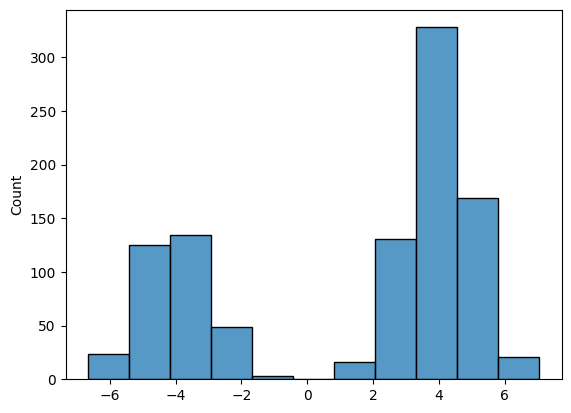

In [44]:
data_distribution = torch.distributions.mixture_same_family.MixtureSameFamily(
    torch.distributions.Categorical(torch.tensor([1, 2])),
    torch.distributions.Normal(torch.tensor([-4., 4.]), torch.tensor([1., 1.]))
)

dataset = data_distribution.sample(torch.Size([1000, 1]))
sns.histplot(dataset[:, 0])
plt.show()

In [45]:
TIME_STEPS = 500
BETA = 0.02

In [46]:
def do_diffusion(data, steps=TIME_STEPS, beta=BETA):
    # perform diffusion following equation 2
    # returns a list of q(x(t)) and x(t)
    # starting from t=0 (i.e., the dataset)

    distributions, samples = [None], [data]
    xt = data
    for t in range(steps):
        q = torch.distributions.Normal(
            np.sqrt(1 - beta) * xt,
            np.sqrt(beta)
        )
        xt = q.sample()

        distributions.append(q)
        samples.append(xt)

    return distributions, samples

In [47]:
_, samples = do_diffusion(dataset)

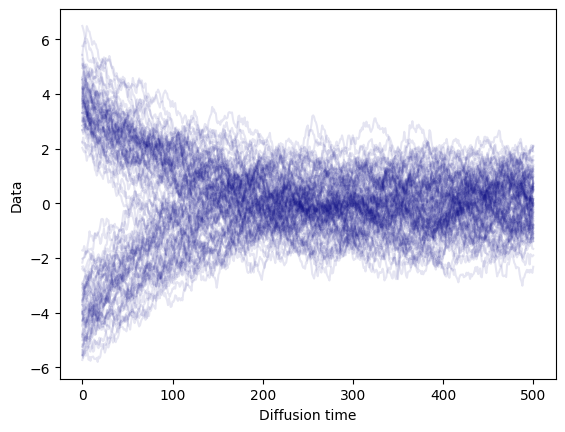

In [48]:
for t in torch.stack(samples)[:, :, 0].T[:100]:
    plt.plot(t, c='navy', alpha=0.1)
plt.xlabel('Diffusion time')
plt.ylabel('Data')
plt.show()

In [49]:
def compute_loss(forward_distributions, forward_samples, mean_model, var_model):
    # here we compute the loss in equation 3
    # forward = q , reverse = p

    # loss for x(T)
    p = torch.distributions.Normal(
        torch.zeros(forward_samples[0].shape),
        torch.ones(forward_samples[0].shape)
    )
    loss = -p.log_prob(forward_samples[-1]).mean()

    for t in range(1, len(forward_samples)):
        xt = forward_samples[t]         # x(t)
        xprev = forward_samples[t - 1]  # x(t-1)
        q = forward_distributions[t]    # q( x(t) | x(t-1) )

        # normalize t between 0 and 1 and add it as a new column
        # to the inputs of the mu and sigma networks
        xin = torch.cat(
            (xt, (t / len(forward_samples)) * torch.ones(xt.shape[0], 1)),
            dim=1
        )
        # compute p( x(t-1) | x(t) ) as equation 1
        mu = mean_model(xin)
        sigma = var_model(xin)
        p = torch.distributions.Normal(mu, sigma)

        # add a term to the loss
        loss -= torch.mean(p.log_prob(xprev))
        loss += torch.mean(q.log_prob(xt))

    return loss / len(forward_samples)

In [50]:
mean_model = torch.nn.Sequential(
    torch.nn.Linear(2, 4), torch.nn.ReLU(),
    torch.nn.Linear(4, 1)
)
var_model = torch.nn.Sequential(
    torch.nn.Linear(2, 4), torch.nn.ReLU(),
    torch.nn.Linear(4, 1), torch.nn.Softplus()
)

In [51]:
optim = torch.optim.AdamW(
    itertools.chain(mean_model.parameters(), var_model.parameters()),
    lr=1e-2, weight_decay=1e-6,
)

loss_history = []
bar = tqdm(range(1000))
for e in bar:
    forward_distributions, forward_samples = do_diffusion(dataset)

    optim.zero_grad()
    loss = compute_loss(
        forward_distributions, forward_samples, mean_model, var_model
    )
    loss.backward()
    optim.step()

    bar.set_description(f'Loss: {loss.item():.4f}')
    loss_history.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

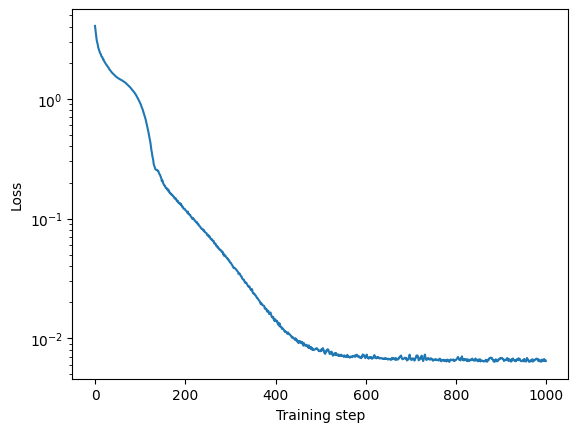

In [52]:
plt.plot(loss_history)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training step')
plt.show()

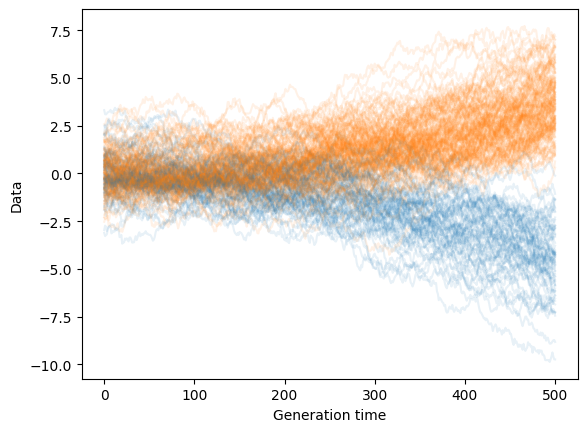

In [53]:
def sample_reverse(mean_model, var_model, count, steps=TIME_STEPS):
    p = torch.distributions.Normal(torch.zeros(count, 1), torch.ones(count, 1))
    xt = p.sample()
    sample_history = [xt]
    for t in range(steps, 0, -1):
        xin = torch.cat((xt, t * torch.ones(xt.shape) / steps), dim=1)
        p = torch.distributions.Normal(
            mean_model(xin), var_model(xin)
        )
        xt = p.sample()
        sample_history.append(xt)
    return sample_history

samps = torch.stack(sample_reverse(mean_model, var_model, 1000))

for t in samps[:,:,0].T[:200]:
    plt.plot(t, c='C%d' % int(t[-1] > 0), alpha=0.1)
plt.xlabel('Generation time')
plt.ylabel('Data')
plt.show()

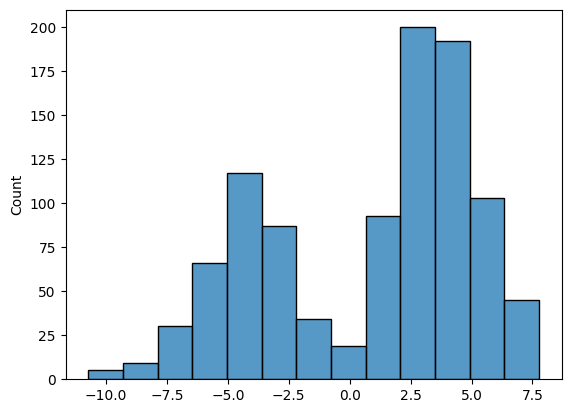

In [54]:
sns.histplot(samps[-1, :, 0])
plt.show()

In [55]:
!pip install diffusers

In [1]:

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'cpu'

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([1, 2, 2, 3, 7, 0, 4, 6])


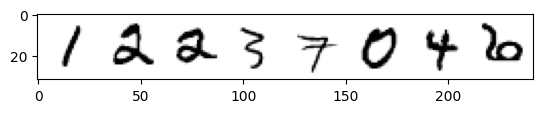

In [2]:
# Load the dataset
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

# Feed it into a dataloader (batch size 8 here just for demo)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# View some examples
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

In [3]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()
    
    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64), 
        down_block_types=( 
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ), 
        up_block_types=(
            "AttnUpBlock2D", 
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape
    
    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [4]:

# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [5]:
#@markdown Training loop (10 Epochs):

# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our network 
net = ClassConditionedUnet().to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# # The training loop
# for epoch in range(n_epochs):
#     for x, y in tqdm(train_dataloader):
        
#         # Get some data and prepare the corrupted version
#         x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
#         y = y.to(device)
#         noise = torch.randn_like(x)
#         timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
#         noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

#         # Get the model prediction
#         pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

#         # Calculate the loss
#         loss = loss_fn(pred, noise) # How close is the output to the noise

#         # Backprop and update the params:
#         opt.zero_grad()
#         loss.backward()
#         opt.step()

#         # Store the loss for later
#         losses.append(loss.item())

#     # Print out the average of the last 100 loss values to get an idea of progress:
#     avg_loss = sum(losses[-100:])/100
#     print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# # View the loss curve
# plt.plot(losses)


state_dict = torch.load('/projectnb/ds598/admin/xthomas/sp2024_notebooks/discussion/disc10/path_to_save_your_model.pth', map_location=torch.device('cpu'))
net.load_state_dict(state_dict)

<All keys matched successfully>

0it [00:00, ?it/s]

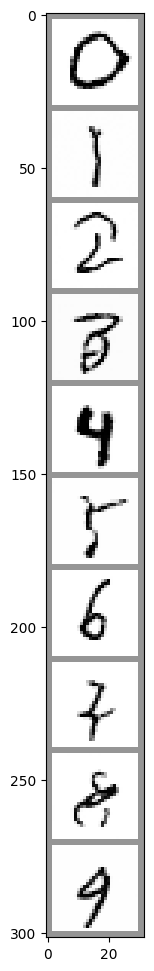

In [6]:
#@markdown Sampling some different digits:

# Prepare random x to start from, plus some desired labels y
x = torch.randn(10, 1, 28, 28).to(device)
y = torch.tensor([[i]*1 for i in range(10)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=1)[0], cmap='Greys')

## Hugging Face Diffusers and Stable Diffusion

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*HMK6Kw0smilQ9abp.png)

* Condition on the Prompt / Text

In [ ]:
!pip install -qq -U diffusers transformers

In [7]:
import os

# Set your desired cache directory path
cache_directory = "/projectnb/ds598/admin/xthomas/sp2024_notebooks/discussion/tmp"

# Set the HF_HOME environment variable for the diffusers library cache
os.environ["HF_HOME"] = cache_directory

# Set the TRANSFORMERS_CACHE environment variable
os.environ["TRANSFORMERS_CACHE"] = cache_directory


In [8]:
from diffusers import StableDiffusionPipeline

* Pipelines enable to carry out inference on models.

In [9]:
pipe = StableDiffusionPipeline.from_pretrained('CompVis/stable-diffusion-v1-4', cache_dir = cache_directory)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# Initialize a prompt
prompt = "a dog wearing hat"
# Pass the prompt in the pipeline
pipe(prompt).images[0]

![title](https://miro.medium.com/v2/resize:fit:1024/format:webp/0*udODoCD9e37_Az8I.png)

* The original Diffusion model tends to consume a lot more memory, so latent diffusion models were created which can do the diffusion process in lower dimension space called Latent Space. 
* Three main components in latent diffusion models:
    - A text encoder, in this case, a CLIP Text encoder
    - An autoencoder, in this case, a Variational Auto Encoder also referred to as VAE
    - A U-Net

###  CLIP Text Encoder

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*lG2abynBvLOYGBgc.png)

In [10]:
import torch, logging
## disable warnings
logging.disable(logging.WARNING)  
## Import the CLIP artifacts 
from transformers import CLIPTextModel, CLIPTokenizer
## Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14",  cache_dir=cache_directory)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14",  cache_dir=cache_directory)

In [11]:
prompt = ["a dog wearing hat"]
tok =tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt") 
print(tok.input_ids.shape)
tok

torch.Size([1, 77])


{'input_ids': tensor([[49406,   320,  1929,  3309,  3801, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [12]:
for token in list(tok.input_ids[0,:7]): 
    print(f"{token}:{tokenizer.convert_ids_to_tokens(int(token))}")

49406:<|startoftext|>
320:a</w>
1929:dog</w>
3309:wearing</w>
3801:hat</w>
49407:<|endoftext|>
49407:<|endoftext|>


In [13]:
emb = text_encoder(tok.input_ids)[0]
print(f"Shape of embedding : {emb.shape}")

Shape of embedding : torch.Size([1, 77, 768])


## Variational Auto Encoder

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*kKahWKJ-kGJ4TAin.png)

* The Encoder acts like a compressor that squishes the image into lower dimensions and the decoder recreates the original image back from the compressed version.

In [ ]:
# from diffusers import AutoencoderKL 
# vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*gPRqgpdKRZlQfurR.png)

### Why use a VAE?

- Stable diffusion can be done without the VAE component but the reason we use VAE is to reduce the computational time to generate High-resolution images.
- The latent diffusion models can perform diffusion in this latent space produced by the VAE encoder and once we have our desired latent outputs produced by the diffusion process, we can convert them back to the high-resolution image by using the VAE decoder.

## U-Net Model

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*4CMZbQvwXaSjQRRX.png)

The U-Net model takes two inputs -
1. Noisy latent or Noise- Noisy latents are latents produced by a VAE encoder (in case an initial image is provided) with added noise or it can take pure noise input in case we want to create a random new image based solely on a textual description
2. Text embeddings - CLIP-based embedding generated by input textual prompts

The output of the U-Net model is the predicted noise residual which the input noisy latent contains. In other words, it predicts the noise which is subtracted from the noisy latents to return the original de-noised latents.

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*KczbjUFsEQRXlA5h.png)

## Overview — The Diffusion Process

![title](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*z5eQUBRBVtgD3Vgv.png)

* The stable diffusion model takes the textual input and a seed. 
* The textual input is then passed through the CLIP model to generate textual embedding of size 77x768 and the seed is used to generate Gaussian noise of size 4x64x64 which becomes the first latent image representation.
* Next, the U-Net iteratively denoises the random latent image representations while conditioning on the text embeddings.
* The output of the U-Net is predicted noise residual, which is then used to compute conditioned latents via a scheduler algorithm.
* This process of denoising and text conditioning is repeated N times (We will use 50) to retrieve a better latent image representation. 
* Once this process is complete, the latent image representation (4x64x64) is decoded by the VAE decoder to retrieve the final output image (3x512x512).



![title](https://miro.medium.com/v2/resize:fit:1024/format:webp/0*sRMNCDKvviQwRrNa.gif)

## References:

- https://e-dorigatti.github.io/math/deep%20learning/2023/06/25/diffusion.html
- https://theaisummer.com/diffusion-models/?ref=blog.paperspace.com
- https://ayandas.me/blogs/2021-12-04-diffusion-prob-models.html
- https://github.com/huggingface/diffusion-models-class/blob/main/unit2/02_class_conditioned_diffusion_model_example.ipynb
- https://github.com/huggingface/diffusers
- https://towardsdatascience.com/stable-diffusion-using-hugging-face-501d8dbdd8
